# ModelingToolkit

# 5 Компонентное моделирование

С увеличением размерности моделируемой системы написать итоговую систему уравнений становится сложнее. 

Но, как правило, системы структурированы и состоят из элементов, часто однотипных в своей предметной области. 

МТК, как любая другая система моделирования, позволяет не только автоматически преобразовывать математическую модель системы в моделирующую программу, но и автоматически получать математическую модель всей моделируемой системы по математическим моделям ее отдельных компонентов и описанию связей между ними.

Компонентное моделирование предполагает создание моделей элементов, а затем сборку из них моделей любых сложных систем.

In [1]:
using ModelingToolkit, DifferentialEquations, Plots

In [2]:
@variables t
der = Differential(t)

(::Differential) (generic function with 2 methods)

## 5.1 Компоненты

Создание и использование моделей компонентов (обобщенных элементов) покажем на примере простой системы с двумя элементами

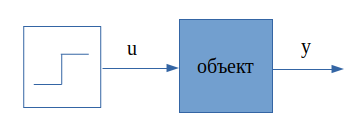

где объект описывается дифференциальным уравнением:

$$ T\frac{dy}{dt} = Ku-y $$

$u$ - входная переменная, $y$ - выходная переменная, $T$ и $K$ - внутренние параметры.

Для каждого элемента создадим функцию, одним из обязательных аргументов которых является `name` - имя создаваемого впоследствии экземпляра элемента. Тело функции включает описание параметров, переменных и уравнений элемента.

### Компонент объекта

In [3]:
@component function Plant(; name, T=1.0, K=1.0, y₀=0.0)
    pars = @parameters T=T  K=K
    vars = @variables u(t)=0 y(t)=y₀
    eqs = T * der(y) ~ (K * u - y)
    ODESystem(eqs, t, vars, pars; name=name)
end

Plant (generic function with 1 method)

### Компонент блока ступенчатого сигнала

In [4]:
@component function Step(; name, height=1.0, start_time=0.0)
    vars = @variables y(t)=0.0
    eqs = y ~ ifelse(t < start_time, 0, height)
    ODESystem(eqs, t, vars, []; name)
end

Step (generic function with 1 method)

### Экземпляры компонентов

Создание конкретных экземпляров компонентов выполним с помощью макроса `@named`, назвав их `plant` и `step`.

In [5]:
@named plant = Plant(K=1.2)
@named step = Step(start_time=1)

Model step with 1 equations
States (1):
  y(t) [defaults to 0.0]
Parameters (0):

после чего определим уравнения соединения их друг с другом:

### Уравнения связи

In [6]:
connections = [
    plant.u ~ step.y
]

1-element Vector{Equation}:
 plant₊u(t) ~ step₊y(t)

### Сборка системы из компонентов

Собираем все уравнения в одну систему

In [7]:
@named model = ODESystem(connections, t; systems = [plant, step])

Model model with 3 equations
States (3):
  plant₊u(t) [defaults to 0]
  step₊y(t) [defaults to 0.0]
  plant₊y(t) [defaults to 0.0]
Parameters (2):
  plant₊T [defaults to 1.0]
  plant₊K [defaults to 1.2]

Далее, как обычно, выполняем структурные преобразования

In [8]:
sys = structural_simplify(model)

Model model with 1 equations
States (1):
  plant₊y(t) [defaults to 0.0]
Parameters (2):
  plant₊T [defaults to 1.0]
  plant₊K [defaults to 1.2]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

и решаем с помощью решателей пакета DifferentialEquations.jl

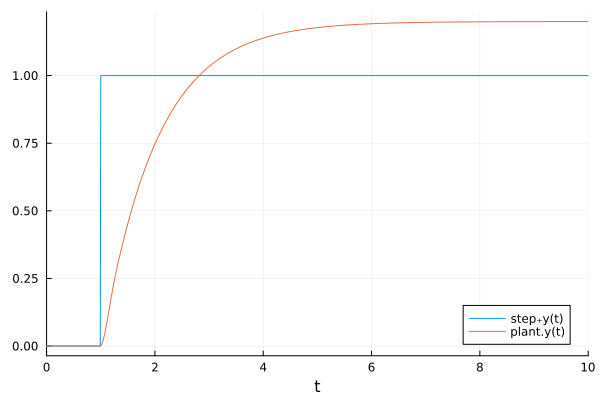

In [9]:
prob = ODEProblem(sys, [], (0, 10.0))
sol = solve(prob)
plot(sol, idxs = [step.y, plant.y])

### Создание множественных экземпляров

Имея обобщенный компонент, оформленный в виде функции, мы можем создавать множество его экземпляров и строить более сложные системы

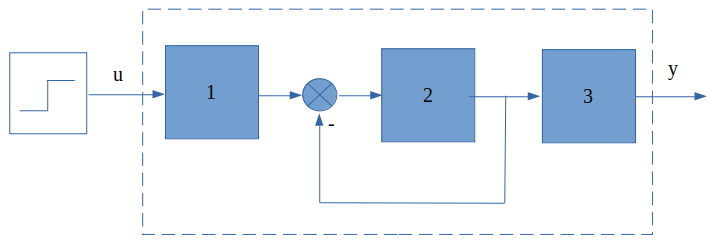

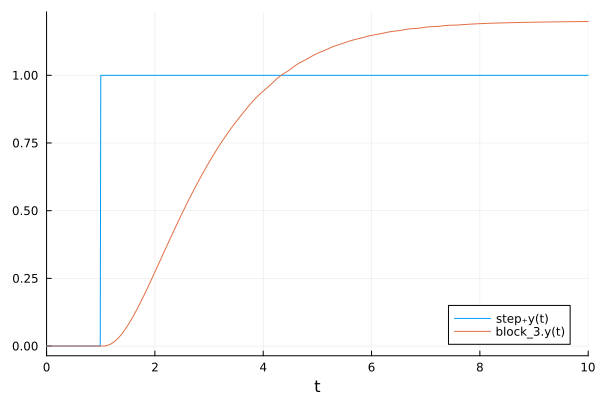

In [10]:
@named block_1 = Plant(K=1.2)
@named block_2 = Plant(T=2)
@named block_3 = Plant(K=2, T=0.1)
@named step = Step(start_time=1)

connections = [
    step.y ~ block_1.u
    block_1.y - block_2.y ~ block_2.u
    block_2.y ~ block_3.u
]

@named model = ODESystem(connections, t; systems = [block_1, block_2, block_3, step])
sys = structural_simplify(model)

prob = ODEProblem(sys, [], (0, 10))
sol = solve(prob)
plot(sol, idxs = [step.y, block_3.y])

## 5.2 Коннекторы

При моделировании физических систем целесообразнее и удобнее использовать _коннекторы_ - порты определяющие взаимодействие между компонентами. 

Коннекторы имеют как минимум две переменные и не имеют уравнений. Одна переменная ассоциируется с обменом веществом, частиц, заряда, энергии, силы, момента и пр. между компонентами. Ее называют **переменной потока**. Другая переменная называется **переменной потенциала**. Типичные примеры - температура, напряжение, давление, скорость.

Определяется коннектор в виде функции, в которой потоковые переменные маркируются как `Flow`.

Пример определения коннектора для элементов электрической цепи:

In [11]:
@connector function Pin(; name)
    vars = @variables(
        v(t)=0,                    # потенциал напряжения
        i(t)=0, [connect = Flow]   # ток
    )
    ODESystem(Equation[], t, vars, []; name = name)
end

Pin (generic function with 1 method)

Пример определения коннектора для элементов механических систем с поступательным движением:

In [12]:
@connector function Flange(; name)
    vars = @variables(
        s(t)=0,                     # скорость
        f(t)=0, [connect = Flow]    # сила
    )
    ODESystem(Equation[], t, vars, [], name = name)
end

Flange (generic function with 1 method)

При соединении двух портов, соответствующие коннектору переменные потенциала идентичны, а соответствующие коннектору потоковые переменные определены уравнением с нулевой суммой (сумма всех соответствующих переменных `Flow` равна нулю).

## 5.3 Пример компонентного моделирования электрической цепи

Электрическая цепь (раздел 1.3) состоит из источника, двух резисторов и индуктивности:

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)


Каждый из этих элементов имеет два разъема. Например, резистор имеет две ножки, значит модель резистора должна содержать два коннектора, например, `p` и `n`. Условно будем считать, что ток через элемент протекает в направлении от ножки `p` к ножке `n`.

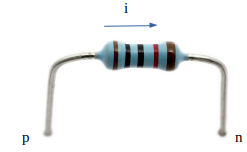

### 5.3.1 Обобщенные компоненты

In [13]:
# Модель обобщенного резистора
@component function Resistor(; name, R=1.0)

    @named p = Pin()          # ножки резистора
    @named n = Pin()           

    pars = @parameters R=R
    vars = @variables(
        v(t)=0,               # напряжение на резисторе
        i(t)=0,               # ток, протекающий через резистор
    )
    
    eqs =[
        0 ~ p.i + n.i         # закон сохранения электрического заряда
        v ~ p.v - n.v         # разность потенциалов на ножках резистора
        i ~ p.i             
        v ~ i * R             # закон Ома для резистивного элемента
    ]
    ODESystem(eqs, t, vars, pars, name=name, systems=[p, n])
end

# Модель обобщенной индуктивности
@component function Inductor(; name, L=1.0)
    
    @named p = Pin()
    @named n = Pin()
    
    pars = @parameters L=L
    vars = @variables(
        v(t)=0,
        i(t)=0,
    )
    
    eqs =[
        0 ~ p.i + n.i     
        v ~ p.v - n.v    
        i ~ p.i             
        v ~ L * der(i)        # закон Ома для индуктивного элемента
    ]
    ODESystem(eqs, t, vars, pars, name=name, systems=[p, n])
end

# Модель обобщенного источника напряжения
@component function Source(; name, V=1.0)
    
    @named p = Pin()
    @named n = Pin()
    
    pars = @parameters V=V
    vars = @variables(
        v(t)=V,
        i(t)=0
    )
    eqs = [
        0 ~ p.i + n.i     
        v ~ p.v - n.v     
        i ~ p.i             
        v ~ V
    ]
    ODESystem(eqs, t, vars, pars, name=name, systems=[p, n])
end
    
# Чтобы не токнуло при расчете, добавим заземление
@component function Ground(; name)
    @named g = Pin()
    eqs = g.v ~ 0
    ODESystem(eqs, t, name=name, systems=[g])
end

Ground (generic function with 1 method)

Не трудно заметить, что определения компонентов резистора, индуктивности и источника имеют много общих элементов описания. В документации приводится пример (https://docs.sciml.ai/ModelingToolkit/stable/tutorials/acausal_components/), демонстрирующий объектно-ориентированный подход в MTK, когда вместо записи уравнений баланса для каждого из компонентов, предварительно создается модель порта из двух коннекторов `OnePort`, содержащая уравнения баланса, после чего она наследуется каждым из компонентов. Таким образом код, который используется в нескольких компонентах, реализуется единожды, что экономит время на его реализацию.

### 5.3.2 Создание модели цепи

#### Экземпляры компонентов

In [14]:
@named source = Source(V=10)
@named resistor1 = Resistor(R=0.2)
@named resistor2 = Resistor(R=0.2)
@named inductor = Inductor(L=0.01)
@named ground = Ground()

Model ground with 1 (2) equations
States (2):
  g₊v(t) [defaults to 0]
  g₊i(t) [defaults to 0]
Parameters (0):

In [15]:
states(resistor1)

6-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 v(t)
 i(t)
 p₊v(t)
 p₊i(t)
 n₊v(t)
 n₊i(t)

#### Уравнения соединений

Cоединение элементов в цепь с использованием функции `connect`

In [16]:
connections = [
    connect(source.p, resistor1.p)
    connect(resistor1.n, resistor2.p, inductor.p)
    connect(resistor2.n, inductor.n, source.n, ground.g)
]

3-element Vector{Equation}:
 connect(source.p, resistor1.p)
 connect(resistor1.n, resistor2.p, inductor.p)
 connect(resistor2.n, inductor.n, source.n, ground.g)

Без коннекторов, пришлось бы расписывать уравнения связи вручную. MTK же сгенерирует эти уравнения автоматически

#### Сборка уравнений всей системы

In [17]:
@named Circuit = ODESystem(connections, t; 
    systems = [ resistor1, resistor2, inductor, ground, source])

Model Circuit with 17 (26) equations
States (26):
  resistor1₊v(t) [defaults to 0]
  resistor1₊i(t) [defaults to 0]
  resistor1₊p₊v(t) [defaults to 0]
  resistor1₊p₊i(t) [defaults to 0]
  resistor1₊n₊v(t) [defaults to 0]
  resistor1₊n₊i(t) [defaults to 0]
⋮
Parameters (4):
  resistor1₊R [defaults to 0.2]
  resistor2₊R [defaults to 0.2]
  inductor₊L [defaults to 0.01]
  source₊V [defaults to 10]

Чтобы увидеть уравнения связи, скрывающиеся под `connect`, применим функцию `expand_connections`. Полная система уравнений модели электрической цепи:

In [18]:
expand_connections(Circuit)

Model Circuit with 26 equations
States (26):
  resistor1₊v(t) [defaults to 0]
  resistor1₊i(t) [defaults to 0]
  resistor1₊p₊v(t) [defaults to 0]
  resistor1₊p₊i(t) [defaults to 0]
  resistor1₊n₊v(t) [defaults to 0]
  resistor1₊n₊i(t) [defaults to 0]
⋮
Parameters (4):
  resistor1₊R [defaults to 0.2]
  resistor2₊R [defaults to 0.2]
  inductor₊L [defaults to 0.01]
  source₊V [defaults to 10]

Как видно, система содержит много псевдонимов, которые можно исключить с помощью преобразования `alias_elimination` (см. раздел 2)

In [19]:
alias_elimination(expand_connections(Circuit))

Model Circuit with 7 equations
States (7):
  inductor₊i(t) [defaults to 0]
  resistor1₊v(t) [defaults to 0]
  resistor1₊i(t) [defaults to 0]
  resistor2₊i(t) [defaults to 0]
  inductor₊v(t) [defaults to 0]
  source₊v(t) [defaults to source₊V]
⋮
Parameters (4):
  resistor1₊R [defaults to 0.2]
  resistor2₊R [defaults to 0.2]
  inductor₊L [defaults to 0.01]
  source₊V [defaults to 10]

А лучше сразу выполнить все структурные преобразования, в результате чего она упрощается, как и ранее, до двух уравнений:

In [20]:
sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  inductor₊i(t) [defaults to 0]
  inductor₊v(t) [defaults to 0]
Parameters (4):
  resistor1₊R [defaults to 0.2]
  resistor2₊R [defaults to 0.2]
  inductor₊L [defaults to 0.01]
  source₊V [defaults to 10]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×
 ×  ⋅  ×

#### Численный расчет

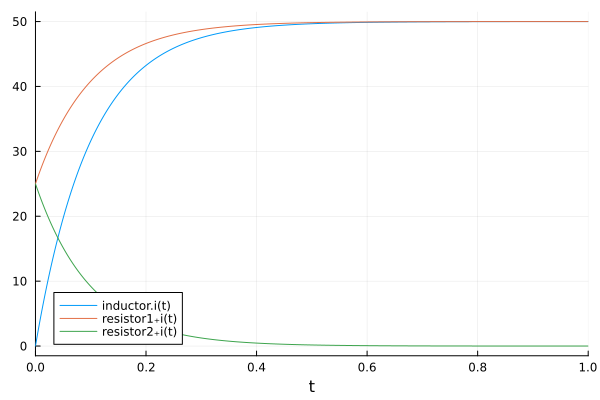

In [21]:
prob = ODEProblem(sys, [], (0, 1.0))
sol = solve(prob)
plot(sol, idxs = [inductor.i, resistor1.i, resistor2.i])

Как уже можно было заметить, доступ к переменным компонентов производиться через `.` Пересчитаем модель, изменив значения ее параметров (увеличив напряжение источника и уменьшив индуктивность):

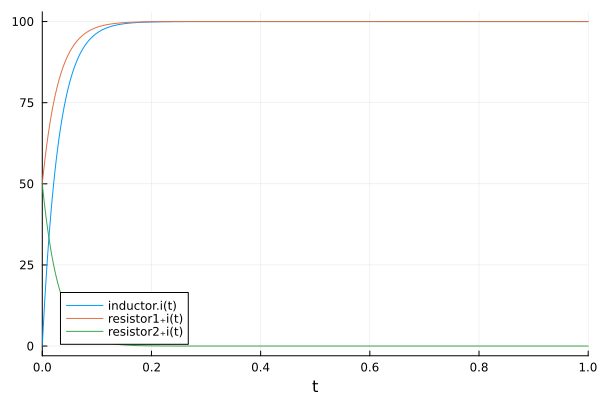

In [22]:
prob = ODEProblem(sys, [], (0, 1.0), [source.V=>20, inductor.L=>0.003])
sol = solve(prob)
plot(sol, idxs = [inductor.i, resistor1.i, resistor2.i])